In [84]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from bs_fdbck.constants import measurements_path, path_outdata, path_extract_latlon_outdata
import dask.array as da
from dask.diagnostics import ProgressBar
import seaborn as sns



In [85]:
def make_fn(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_{case}_{_x}_{_y}.png'
    return plot_path /f



In [86]:
xr.set_options(keep_attrs=True) 

### Settings

In [87]:
lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

In [88]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15  # K

In [89]:
case_name = 'OsloAero_intBVOC_pertSizeDist_f19_f19_mg17_full'

In [90]:
fn = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0.nc'
fn_comb_lev1 = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1.nc'
fn_comb_lev1_final = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_comb_lev1_final_csv = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv'

In [91]:

cases = [case_name]

In [92]:
plot_path = Path('Plots')

In [93]:
varl =['DOD500','DOD440','ACTREL','ACTNL','TGCLDLWP', #,'SOA_A1',
       'H2SO4','SOA_LV','COAGNUCL','FORMRATE','T'
       ,'FCTL',
       'TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP',
       'CLDFREE',
      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3', 
       'FSDSC','FSDSCDRF'
      ]

## Station variables

In [94]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
                 ]


varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

## If file not already createad already, skip this part

In [95]:
def compute_total_tau(ds_mod):
    ds_mod['TOT_ICLD_VISTAU_s'] = ds_mod['TOT_ICLD_VISTAU'].sum('lev')
    ds_mod['TOT_CLD_VISTAU_s'] = ds_mod['TOT_CLD_VISTAU'].sum('lev')
    return ds_mod

In [96]:
if not fn_comb_lev1.exists():
    ds_mod = xr.open_dataset(fn, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
    #ds_mod2 = xr.open_dataset(fn2, chunks = {'time':48})

    ds_mod = compute_total_tau(ds_mod)

    ds_mod = ds_mod.sortby('time')#.sel(time=slice('2012','2014'))

    ds_mod = ds_mod.isel(lev = model_lev_i)


    delayed_obj = ds_mod.to_netcdf(fn_comb_lev1, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

## If file createad already, skip to here

### Select hyytiala grid cell: 

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [97]:
def broadcase_station_data(ds_all):
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')
    ds_1, ds_2 =xr.broadcast(ds_sel, ds_all)
    for v in varl_st:
        ds_all[v] = ds_1[v]

    return ds_all


def compute_optical_thickness(ds):
    SW_down_surf = ds['FSDS_DRF']


    SW_down_surf_cs = ds['FSDSCDRF']


    transmittance = SW_down_surf/SW_down_surf_cs




    opt_depth = - np.log(transmittance)


    ds['optical_depth'] =  opt_depth
    return ds

def change_units_and_compute_vars(ds):


    ds = ds.where(ds['CLDFREE']<0.8)
    for v in ['TGCLDLWP', 'TGCLDIWP', 'TGCLDCWP']:
        if v in ds.data_vars:
            if ds[v].attrs['units'] == 'kg/m2':
                ds[v] = ds[v] * 1000
                ds[v].attrs['units'] = 'g/m2'
    if temperature is not None:
        T = temperature
    else:
        T = ds['T']
    rho = pressure * 100 / (R * T)
    ds['rho'] = rho
    for v in ['ACTNL','AWNC']:
        if ds[v].attrs['units']=='m-3':
            ds[v] = ds[v]*1e-6 #m-3--> cm-3
            ds[v].attrs['units'] = 'cm$^{-3}$'
    ds['ACTNL_incld'] = ds['ACTNL'] / ds['FCTL']
    ds['ACTREL_incld'] = ds['ACTREL'] / ds['FCTL']
    ds['T_C'] = ds['T'] - 273.15

    ds['TGCLDCWP_incld'] = ds['TGCLDCWP'] / (1 - ds['CLDFREE'])
    ds['TGCLDLWP_incld'] = ds['TGCLDLWP'] / (1 - ds['CLDFREE'])
    ds = ds.where(ds['CLDFREE'] < 1)
    ls_so4 = [c for c in ds.data_vars if 'SO4_' in c]  # ['SO4_NA']
    for s in ['SOA_NA', 'SOA_A1', 'OM_AC', 'OM_AI', 'OM_NI'] + ls_so4:
        un = '$\micro$g/m3'
        if ds[s].attrs['units'] != un:
            ds[s] = ds[s] * ds['rho'] * kg2ug
            ds[s].attrs['units'] = un
    ds['SOA'] = ds['SOA_NA'] + ds['SOA_A1']
    ds['OA'] = ds['SOA_NA'] + ds['SOA_A1'] + ds['OM_AC'] + ds['OM_AI'] + ds['OM_NI']
    ds['POA'] = ds['OM_AC'] + ds['OM_AI'] + ds['OM_NI']
    ds['SO4'] = 0



    for s in ls_so4:
        print(s)

        # print(ds[s].mean())
        ds['SO4'] = ds['SO4'] + ds[s]

    ds = compute_optical_thickness(ds)
    return ds

In [98]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb_lev1).isel(ilev=model_lev_i)
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        #ilev=-1,
        # cosp_tau_modis=0,
        #                                                    cosp_tau=0,
        #                                                   cosp_dbze=0,
        #                                                    cosp_ht=0,
        #                                                    cosp_prs = 0,
        #                                                   cosp_reffice=0,
        #                                                    cosp_htmisr=0,
        #                                                    cosp_reffliq=0,
        #                                                    cosp_scol=0,
        #                                                    cosp_sr=0,
        #                                                    cosp_sza=0,
        nbnd=0
    ).squeeze()
    ds_all = broadcase_station_data(ds_all)
    ds_all = change_units_and_compute_vars(ds_all)


    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

### Broadcast ds_sel to same grid

In [99]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

In [100]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [101]:
def get_dic_df_mod():

    dic_df = dict()
    #dic_df_sm = dict()

    for ca in dic_ds.keys():


        ds = dic_ds[ca]
        #ds = change_units_and_compute_vars(ds)

        print('hallo')
        print(ds)
        ds['hour'] = ds['time.hour']
        hours_we_want = (ds['hour']>8) &   (ds['hour']<14)
        for v in varl_cl:
            if v in ds.data_vars:
                ds[v] = ds[v].where(hours_we_want)



        ds_sel_median = ds.resample({'time':'D'}).median()



        ds_sel_median['month']=ds_sel_median['time.month']
        #df_s['ACTNL'].plot()
        ds_sel_median['isJuly'] = ds_sel_median['month']==7
        ds_sel_median['isAug'] = ds_sel_median['month']==8
        ds_sel_median['isSummer'] = (ds_sel_median['isJuly'] |ds_sel_median['isAug'])

        #ds_sel_median = ds_sel_median.where(ds_sel_median['month']

        ds_sel_median = ds_sel_median.where(ds_sel_median['isSummer'])#['month']

        df = ds_sel_median.to_dataframe()


        df = df.drop([co for co in df.columns if (('lat_' in co)|('lon_' in co))],
                     axis=1)

        months = (df.index.get_level_values(0).month==7 )|(df.index.get_level_values(0).month==8  )

        df.loc[:,'year'] = df.index.get_level_values(0).year.values

        #df_s.index = df_s.index.rename('date')
        #df_merge = df_s#pd.merge(df_s, df_hyy_1, right_on='date', left_on='date')
        
        #df_s['year'] = df_s.index.get_level_values(0).year

        
        dic_df[ca] = df


    return dic_df




#dic_df = get_dic_df_mod()

In [102]:
if not fn_comb_lev1_final_csv.exists():
    dic_df = get_dic_df_mod()

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_comb_lev1_final_csv)

In [103]:
df_mod = pd.read_csv(fn_comb_lev1_final_csv, index_col=[0,1,2] )

## Clean data:

### Remove gridcells that don't have a lot of cloud?

In [104]:
df_mod = df_mod[df_mod['CLDFREE']<.8]#.index.get_level_values(1)

### Remove grid vells with no cloud top liquid

In [105]:
mask_liq_cloudtop = df_mod['FCTL']>0.0001

In [106]:
df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop

<AxesSubplot:xlabel='time'>

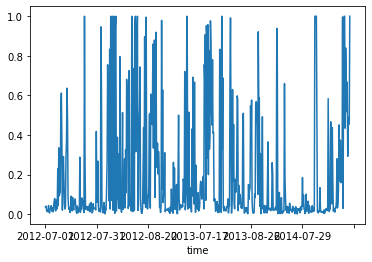

In [107]:
df_mod[mask_liq_cloudtop].reset_index().set_index('time')['FCTL'].plot()#ylim=[-.0,.01])

In [108]:
_df = df_mod.reset_index()

In [109]:
df_mod = df_mod[df_mod['mask_liq_cloudtop']]

## Group by cloud water path

In [110]:
df_mod['CWP_qcut']=pd.qcut(df_mod['TGCLDCWP'],6)# bins=bins, labels=labels)§

df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)



In [111]:
bins = pd.IntervalIndex.from_breaks([ 10,  40,  70,  100, 130, 160, 190,500])
bins = pd.IntervalIndex.from_breaks([ 5,  30,  55,  80, 105, 130, 155,500])


df_mod['CWP_cut']=pd.cut(df_mod['TGCLDCWP'], bins=bins)#, labels=labels)

df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)

## Category of OA concentration

In [112]:
df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)

In [113]:
#df_mod['OA_low'].loc[:,:] = df_mod['OA']<df_mod['OA'].quantile(.34)
mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
df_mod['OA_mid_range'] = mid_range

In [114]:

df_mod=df_mod.assign(OA_category= pd.NA)
df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'



## Distribution plots:

404


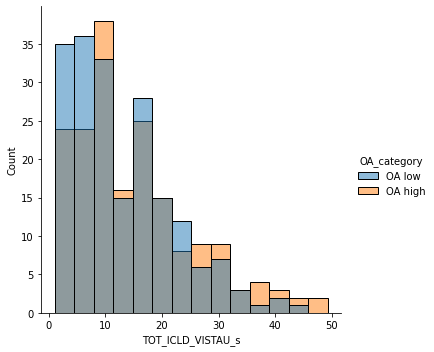

In [115]:
_df = (df_mod[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df[_df['TOT_ICLD_VISTAU_s']<50]
sns.displot(#x='TGCLDLWP', 
            x='TOT_ICLD_VISTAU_s',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


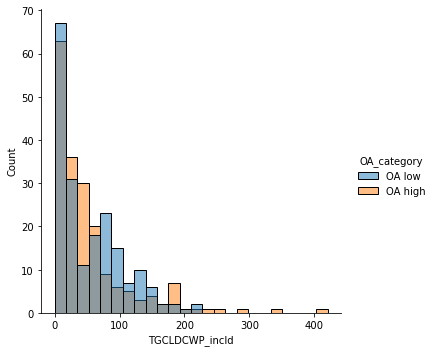

In [116]:
_df = (df_mod[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df[_df['TGCLDCWP_incld']<1000]
sns.displot(#x='TGCLDLWP',
            x='TGCLDCWP_incld',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


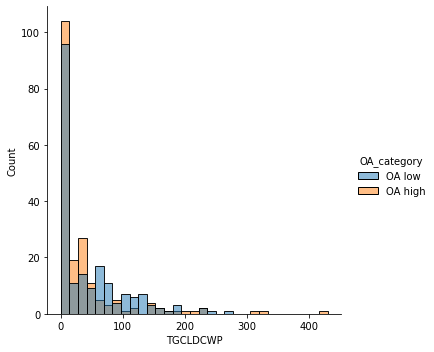

In [117]:
_df = (df_mod[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP_incld']<1000]
sns.displot(#x='TGCLDLWP',
            x='TGCLDCWP',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


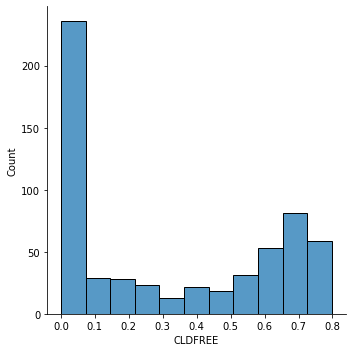

In [118]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>0)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP',
            x='CLDFREE',
            data=_df,
            #hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


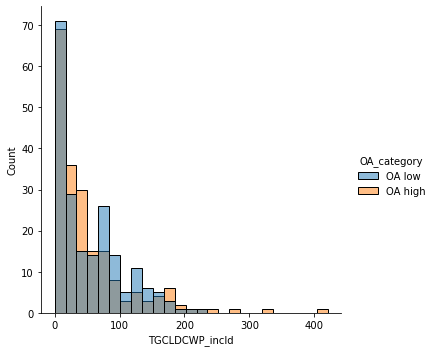

In [119]:
_df = df_mod[df_mod['TGCLDCWP_incld']<9999e99]#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP',
            x='TGCLDCWP_incld',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


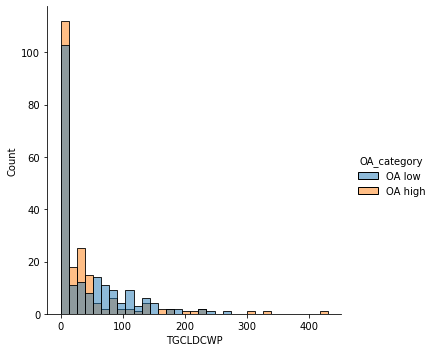

In [120]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP',
            x='TGCLDCWP',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


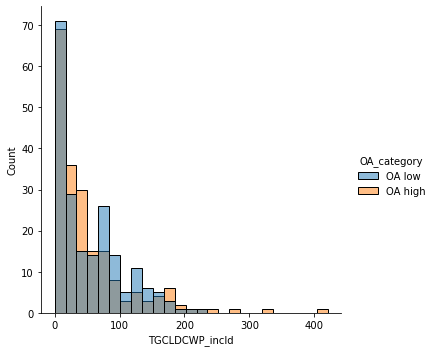

In [121]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP',
            x='TGCLDCWP_incld',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

404


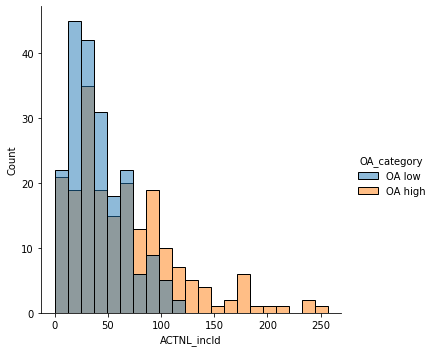

In [122]:
sns.displot(#x='TGCLDLWP',
            x='ACTNL_incld',
            data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[~df_mod['OA_mid_range']]))

In [123]:
import seaborn as sns

593


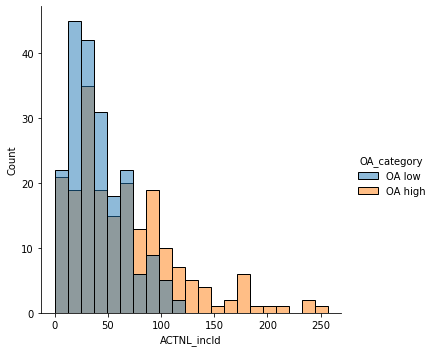

In [124]:
sns.displot(#x='TGCLDLWP', 
            x='ACTNL_incld',
            data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(_df['OA_category']))

<AxesSubplot:xlabel='TGCLDCWP', ylabel='TOT_CLD_VISTAU_s'>

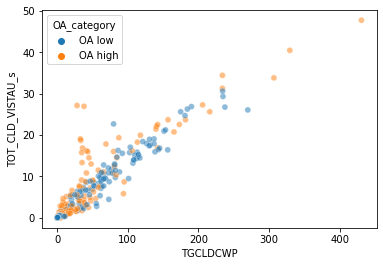

In [125]:
sns.scatterplot(x='TGCLDCWP',
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            alpha=0.5,
            hue='OA_category',
            #kind='swarm',
           )
#plt.ylim([0,52])
#plt.xlim([0,400])

In [126]:
import seaborn as sns

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


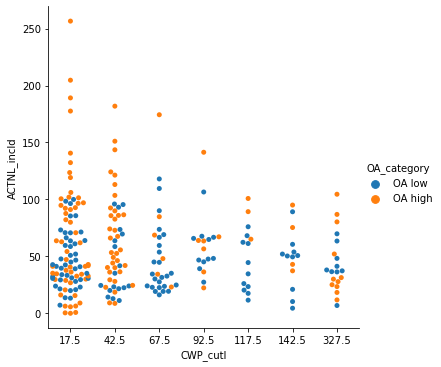

In [127]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='swarm'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


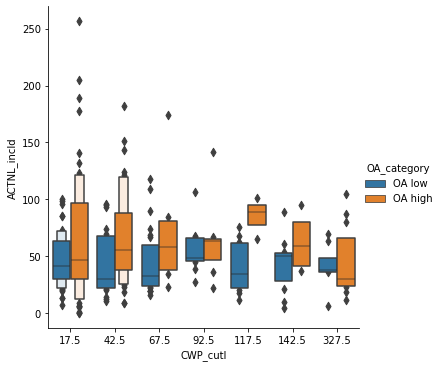

In [128]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='boxen'
           )
#plt.ylim([0cc,250])

## Cloud optical thickness

### Incloud

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

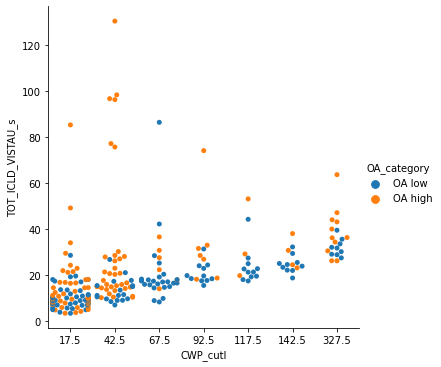

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


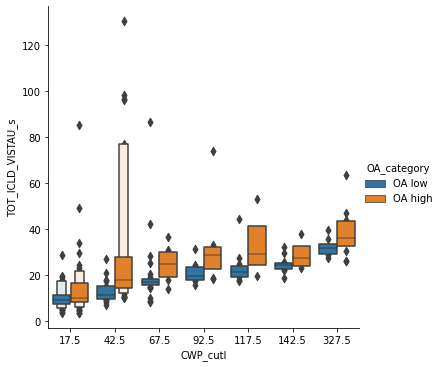

In [134]:
x = 'CWP_cutl'
y = 'TOT_ICLD_VISTAU_s'
ylim = None#[0,52]

sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            #s=4,
            hue='OA_category',
            kind='swarm',
           )
plt.ylim(ylim)
plt.show()
sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim(ylim)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


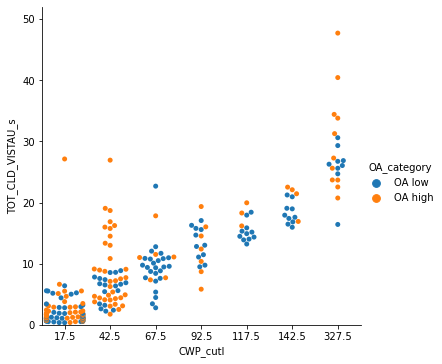

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


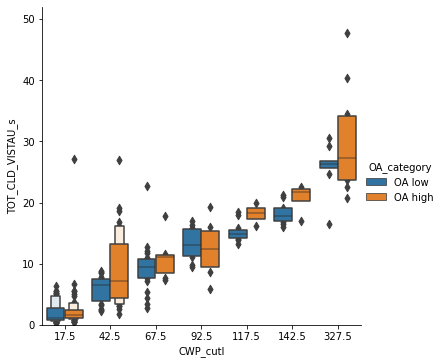

In [130]:
x = 'CWP_cutl'
y = 'TOT_CLD_VISTAU_s'
ylim = [0,52]

sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            #s=4,
            hue='OA_category',
            kind='swarm',
           )
plt.ylim(ylim)
plt.show()
sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim(ylim)
plt.show()

### My computed optical thickness

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


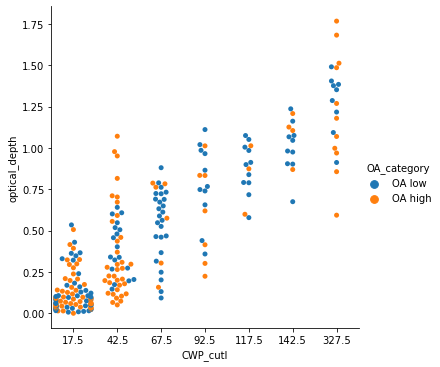

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


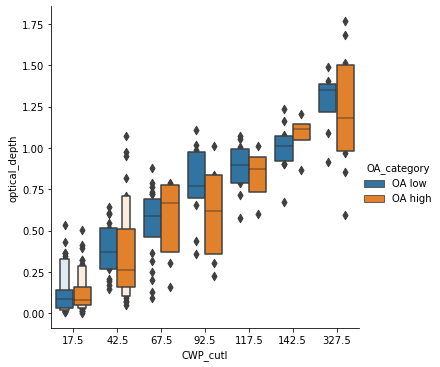

In [131]:
x = 'CWP_cutl'
y = 'optical_depth'
ylim = None# [0,52]

sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            #s=4,
            hue='OA_category',
            kind='swarm',
           )
plt.ylim(ylim)
plt.show()
sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim(ylim)
plt.show()

## Cloud droplet number:

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


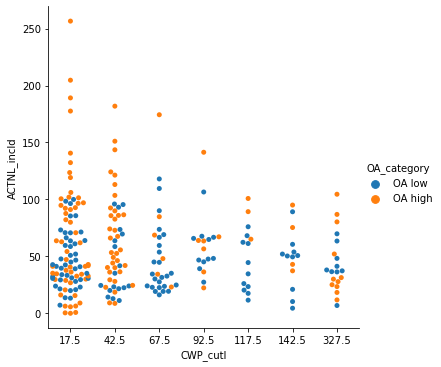

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


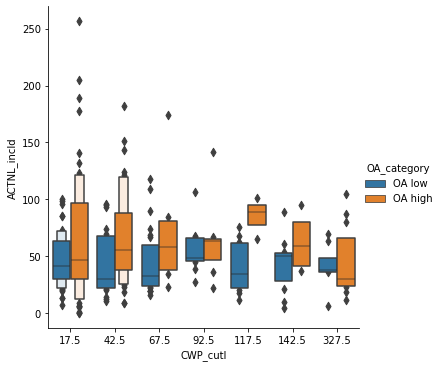

In [132]:
x = 'CWP_cutl'
y = 'ACTNL_incld'
ylim = None# [0,52]

sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            #s=4,
            hue='OA_category',
            kind='swarm',
           )
plt.ylim(ylim)
plt.show()
sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim(ylim)
plt.show()

## Cloud droplet effective radius (ACTREL)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


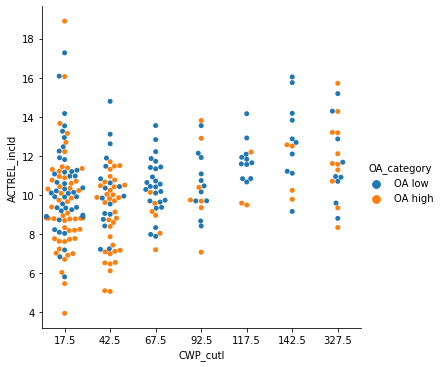

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


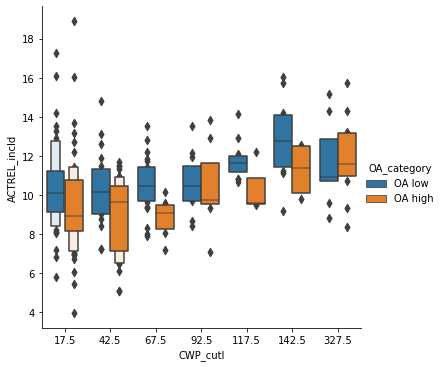

In [133]:
x = 'CWP_cutl'
y = 'ACTREL_incld'
ylim = None# [0,52]

sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            #s=4,
            hue='OA_category',
            kind='swarm',
           )
plt.ylim(ylim)
plt.show()
sns.catplot(x=x,
            y=y,
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim(ylim)
plt.show()